# Reporte de Analítica

## Importar modulos

In [90]:
#import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Recopilación de los datos

## Recopilar datos
aqui debo abrir con API o algo por el estilo

## Organizar y almacenar
Aqui quiero usar una estructura de hdf5

In [50]:
df = pd.read_csv('mexico_covid19.csv', encoding='utf8')
df.head()

,id,FECHA_ARCHIVO,ID_REGISTRO,ENTIDAD_UM,ENTIDAD_RES,RESULTADO,DELAY,ENTIDAD_REGISTRO,ENTIDAD,ABR_ENT,...,OTRA_COM,CARDIOVASCULAR,OBESIDAD,RENAL_CRONICA,TABAQUISMO,OTRO_CASO,MIGRANTE,PAIS_NACIONALIDAD,PAIS_ORIGEN,UCI
0,9269,2020-04-12,00011f,25,25,2,0,25,Sinaloa,SL,...,2,2,1,2,2,2,99,MÃ©xico,97,97
1,33333,2020-04-12,00014e,14,14,2,0,14,Jalisco,JC,...,2,2,1,2,1,99,99,MÃ©xico,97,2
2,35483,2020-04-12,000153,8,8,1,0,8,Chihuahua,CH,...,2,2,2,2,2,99,99,MÃ©xico,97,2
3,7062,2020-04-12,0001b6,9,15,1,0,9,Ciudad de Mexico,DF,...,2,2,1,2,2,99,99,MÃ©xico,97,97
4,23745,2020-04-12,0001c1,9,9,2,0,9,Ciudad de Mexico,DF,...,2,2,2,2,2,99,99,MÃ©xico,97,97


## Preprocesamiento
Limpieza de datos

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 263007 entries, 0 to 263006
Data columns (total 41 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   263007 non-null  int64  
 1   FECHA_ARCHIVO        263007 non-null  object 
 2   ID_REGISTRO          263007 non-null  object 
 3   ENTIDAD_UM           263007 non-null  int64  
 4   ENTIDAD_RES          263007 non-null  int64  
 5   RESULTADO            263007 non-null  int64  
 6   DELAY                263007 non-null  int64  
 7   ENTIDAD_REGISTRO     263007 non-null  int64  
 8   ENTIDAD              263007 non-null  object 
 9   ABR_ENT              263007 non-null  object 
 10  FECHA_ACTUALIZACION  263007 non-null  object 
 11  ORIGEN               263007 non-null  int64  
 12  SECTOR               263007 non-null  int64  
 13  SEXO                 263007 non-null  int64  
 14  ENTIDAD_NAC          263007 non-null  int64  
 15  MUNICIPIO_RES    

In [53]:
df_remove_cols = df.drop(columns = ['id', 'ID_REGISTRO'], inplace=False)
df_remove_cols.head()

,FECHA_ARCHIVO,ENTIDAD_UM,ENTIDAD_RES,RESULTADO,DELAY,ENTIDAD_REGISTRO,ENTIDAD,ABR_ENT,FECHA_ACTUALIZACION,ORIGEN,...,OTRA_COM,CARDIOVASCULAR,OBESIDAD,RENAL_CRONICA,TABAQUISMO,OTRO_CASO,MIGRANTE,PAIS_NACIONALIDAD,PAIS_ORIGEN,UCI
0,2020-04-12,25,25,2,0,25,Sinaloa,SL,2020-04-19,2,...,2,2,1,2,2,2,99,MÃ©xico,97,97
1,2020-04-12,14,14,2,0,14,Jalisco,JC,2020-04-19,1,...,2,2,1,2,1,99,99,MÃ©xico,97,2
2,2020-04-12,8,8,1,0,8,Chihuahua,CH,2020-04-19,1,...,2,2,2,2,2,99,99,MÃ©xico,97,2
3,2020-04-12,9,15,1,0,9,Ciudad de Mexico,DF,2020-04-19,2,...,2,2,1,2,2,99,99,MÃ©xico,97,97
4,2020-04-12,9,9,2,0,9,Ciudad de Mexico,DF,2020-04-19,1,...,2,2,2,2,2,99,99,MÃ©xico,97,97


In [55]:
# The attributes in the list are object type, so we convert each into a datetime type attribute
# FECHA_DEF cannot be coverted into datetime format becasue 9999-99-99 ins't a valid a date, so we replace it with 2200-01-01 which is  valir format and still is outlier.
df_remove_cols['FECHA_DEF'] = df_remove_cols['FECHA_DEF'].replace('9999-99-99', '2200-01-01')


# The attributes in the following list are object type, so we convert each into a datetime type attribute
tipos_de_fechas = ['FECHA_ARCHIVO', 'FECHA_ACTUALIZACION', 'FECHA_INGRESO', 'FECHA_SINTOMAS', 'FECHA_DEF']
for tipo_de_fecha in tipos_de_fechas:
    df_remove_cols[tipo_de_fecha] = pd.to_datetime(df_remove_cols[tipo_de_fecha])

In [92]:
fecha_def = df_remove_cols['FECHA_DEF'][df_remove_cols['FECHA_DEF'] < pd.to_datetime('2030-01-01')]
#fecha_def.sort_values(by='FECHA_DEF')
dict(fecha_def.value_counts()).values()

dict_values([120, 120, 114, 113, 109, 107, 105, 101, 101, 100, 99, 99, 97, 96, 89, 89, 88, 87, 87, 85, 84, 81, 76, 75, 73, 72, 71, 70, 69, 69, 68, 67, 64, 63, 63, 61, 60, 59, 58, 57, 56, 54, 53, 52, 52, 52, 52, 49, 47, 45, 44, 44, 44, 43, 41, 41, 40, 39, 38, 38, 35, 35, 34, 32, 22, 19, 18, 16, 6, 6, 5, 4, 3, 3, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

## Guardar datos limpios en otra estructura

In [87]:
# codigo aqui

# EDA - Análisis Exploratorio de los datos

## Resumen estadística
Calcular estadística descriptiva -> promedio, media, desviación estándar, mínimo, máximo, percentiles, etc.

In [86]:
df.describe()

,id,ENTIDAD_UM,ENTIDAD_RES,RESULTADO,DELAY,ENTIDAD_REGISTRO,ORIGEN,SECTOR,SEXO,ENTIDAD_NAC,...,INMUSUPR,HIPERTENSION,OTRA_COM,CARDIOVASCULAR,OBESIDAD,RENAL_CRONICA,TABAQUISMO,OTRO_CASO,MIGRANTE,UCI
count,2.630070e+05,263007.000000,263007.000000,263007.000000,263007.0,263007.000000,263007.000000,263007.000000,263007.000000,263007.000000,...,263007.000000,263007.000000,263007.000000,263007.000000,263007.000000,263007.000000,263007.000000,263007.000000,263007.000000,263007.000000
mean,2.946176e+06,14.844601,15.127719,1.609672,0.0,15.092271,1.635789,9.601680,1.510682,19.691004,...,2.359667,2.174185,2.453961,2.324980,2.184763,2.320231,2.268217,32.283764,98.593680,74.541012
std,2.212368e+06,8.001043,7.904314,0.487825,0.0,7.915406,0.481209,7.265468,0.499887,19.378113,...,6.021830,5.745114,6.850231,5.796086,5.817362,5.722995,5.867586,45.350310,6.275497,40.384991
min,1.000000e+00,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,8.689635e+05,9.000000,9.000000,1.000000,0.0,9.000000,1.000000,4.000000,1.000000,9.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,99.000000,97.000000
50%,2.733242e+06,14.000000,15.000000,2.000000,0.0,15.000000,2.000000,12.000000,2.000000,15.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,99.000000,97.000000
75%,4.789668e+06,21.000000,21.000000,2.000000,0.0,21.000000,2.000000,12.000000,2.000000,24.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,99.000000,99.000000,97.000000
max,7.277125e+06,32.000000,32.000000,2.000000,0.0,32.000000,2.000000,99.000000,2.000000,99.000000,...,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,99.000000,99.000000,99.000000


## Visualización de los datos
Usar técnicas de visualización como histogramas, gráficas de dispresión, gráficas de barras, diagramas de cajas, entre otros.

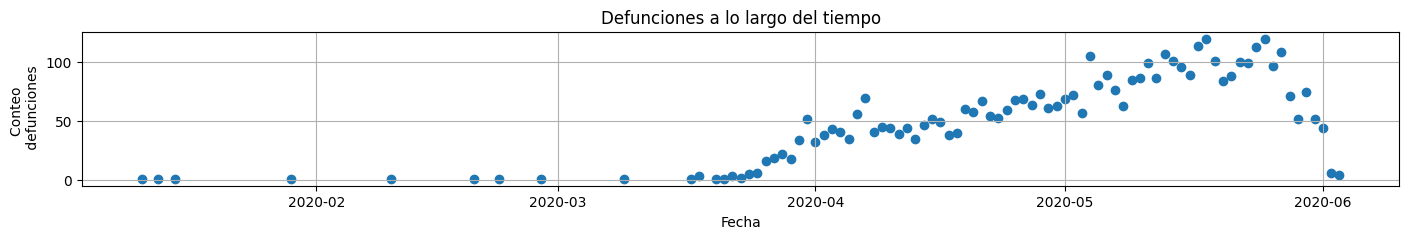

In [85]:
plt.figure(figsize=(17,2))
fechas_defunciones = list(dict(fecha_def.value_counts()).keys())
conteo_defunciones = list(dict(fecha_def.value_counts()).values())
plt.scatter(fechas_defunciones, conteo_defunciones)
plt.grid()
plt.title('Defunciones a lo largo del tiempo')
plt.xlabel('Fecha')
plt.ylabel('Conteo \n defunciones')
plt.show()

In [79]:
fechas_defunciones

[Timestamp('2020-05-18 00:00:00'),
 Timestamp('2020-05-25 00:00:00'),
 Timestamp('2020-05-17 00:00:00'),
 Timestamp('2020-05-24 00:00:00'),
 Timestamp('2020-05-27 00:00:00'),
 Timestamp('2020-05-13 00:00:00'),
 Timestamp('2020-05-04 00:00:00'),
 Timestamp('2020-05-19 00:00:00'),
 Timestamp('2020-05-14 00:00:00'),
 Timestamp('2020-05-22 00:00:00'),
 Timestamp('2020-05-11 00:00:00'),
 Timestamp('2020-05-23 00:00:00'),
 Timestamp('2020-05-26 00:00:00'),
 Timestamp('2020-05-15 00:00:00'),
 Timestamp('2020-05-16 00:00:00'),
 Timestamp('2020-05-06 00:00:00'),
 Timestamp('2020-05-21 00:00:00'),
 Timestamp('2020-05-12 00:00:00'),
 Timestamp('2020-05-10 00:00:00'),
 Timestamp('2020-05-09 00:00:00'),
 Timestamp('2020-05-20 00:00:00'),
 Timestamp('2020-05-05 00:00:00'),
 Timestamp('2020-05-07 00:00:00'),
 Timestamp('2020-05-30 00:00:00'),
 Timestamp('2020-04-28 00:00:00'),
 Timestamp('2020-05-02 00:00:00'),
 Timestamp('2020-05-28 00:00:00'),
 Timestamp('2020-04-07 00:00:00'),
 Timestamp('2020-04-

In [88]:
df_remove_cols.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 263007 entries, 0 to 263006
Data columns (total 39 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   FECHA_ARCHIVO        263007 non-null  datetime64[ns]
 1   ENTIDAD_UM           263007 non-null  int64         
 2   ENTIDAD_RES          263007 non-null  int64         
 3   RESULTADO            263007 non-null  int64         
 4   DELAY                263007 non-null  int64         
 5   ENTIDAD_REGISTRO     263007 non-null  int64         
 6   ENTIDAD              263007 non-null  object        
 7   ABR_ENT              263007 non-null  object        
 8   FECHA_ACTUALIZACION  263007 non-null  datetime64[ns]
 9   ORIGEN               263007 non-null  int64         
 10  SECTOR               263007 non-null  int64         
 11  SEXO                 263007 non-null  int64         
 12  ENTIDAD_NAC          263007 non-null  int64         
 13  MUNICIPIO_RES 

## Análisis de correlación
Puede proporcionar información sobre posibles predicores importantes para un análisis posterior.

## Análisis de distribución de variables
Examina la distribución de las variables en los datos para detectar sesgos o asimetrías.

## Identificación de valores atípicos
Detectar y analizar outliers y anomalías

## Segmentación
Dividir los datos en segmentos o grupos con características similares para analizar patrones específicos en elgrrupo. 

## Exploración de series temporales
Si los datos tienen una dimensión temporal, realizar un análisis de series temporales para identificar tendencias, estacionalidades, y ciclos en los datos a lo largo del tiempo.

# Modelado de datos